# EDA

In [33]:
import pandas as pd
df = pd.read_csv("data/skylab_instagram_datathon_dataset.csv", delimiter=";")
df.head()

,period,period_end_date,compset_group,compset,business_entity_doing_business_as_name,legal_entity_name,domicile_country_name,ultimate_parent_legal_entity_name,primary_exchange_name,calculation_type,followers,pictures,videos,comments,likes
0,Weekly,2019-12-07,Luxury & Premium & Mainstream,Soft Luxury,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,22066189.0,97.0,13.0,16239.0,6112205.0
1,Weekly,2021-01-30,Luxury & Premium & Mainstream,Luxury & Premium & Mainstream,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,24289963.0,54.0,2.0,13358.0,3189144.0
2,Weekly,2016-05-14,Luxury & Premium & Mainstream,Soft Luxury,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,7137442.0,42.0,8.0,15894.0,2152955.0
3,Weekly,2019-04-20,Luxury & Premium & Mainstream,Luxury & Premium & Mainstream,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,18901125.0,73.0,9.0,26762.0,5224916.0
4,Weekly,2023-03-25,Luxury & Premium & Mainstream,US Softlines Analyst Interest List,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,30251374.0,54.0,10.0,25681.0,5760987.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704313 entries, 0 to 704312
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   period                                  704313 non-null  object 
 1   period_end_date                         704313 non-null  object 
 2   compset_group                           704313 non-null  object 
 3   compset                                 704313 non-null  object 
 4   business_entity_doing_business_as_name  704313 non-null  object 
 5   legal_entity_name                       676558 non-null  object 
 6   domicile_country_name                   458589 non-null  object 
 7   ultimate_parent_legal_entity_name       676558 non-null  object 
 8   primary_exchange_name                   458589 non-null  object 
 9   calculation_type                        704313 non-null  object 
 10  followers                               5792

# 1.1 Feature Inspection
For each feature:
- Decide whether to drop or keep
- Check for anomalies
- Check for NAs and where they appear
- Change data type if needed
- Drop any duplicates
- Set new index
- Interpolate missing numerical values if possible

In [35]:
# strip all columns with string values
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [36]:
# missing values per column
df.isnull().sum()

period                                         0
period_end_date                                0
compset_group                                  0
compset                                        0
business_entity_doing_business_as_name         0
legal_entity_name                          27755
domicile_country_name                     245724
ultimate_parent_legal_entity_name          27755
primary_exchange_name                     245724
calculation_type                               0
followers                                 125055
pictures                                    8510
videos                                     19964
comments                                    8970
likes                                       8336
dtype: int64

Given the amount of missing values we drop following features:
- domicile_country_name          
- ultimate_parent_legal_entity_name        
- primary_exchange_name

In [37]:
# drop cols with too many missing values
df = df.drop(columns=["domicile_country_name", "ultimate_parent_legal_entity_name", "primary_exchange_name"])

In [38]:
# unique values in each column
df.nunique()

period                                         1
period_end_date                              455
compset_group                                 20
compset                                       54
business_entity_doing_business_as_name       706
legal_entity_name                            423
calculation_type                               1
followers                                 243231
pictures                                    8190
videos                                      3748
comments                                   52500
likes                                     197943
dtype: int64

Given that they have a unique value we drop the following columns:
- period
- calculation_type

In [39]:
# drop cols with one unique value
df.drop(columns=["period", "calculation_type"], inplace=True)

### feature 2: period_end_date
- End of week day (Saturday)
- x-axis of trend analysis

In [40]:
# period_end_date column
# convert data type to datetime
df["period_end_date"] = pd.to_datetime(df["period_end_date"])

### feature 3: compset_group
The compset is the "industry" in which they are competing.

In [41]:
# compset_group unique values
df['compset_group'].unique()

array(['Luxury & Premium & Mainstream', 'Restaurants', 'Beverages',
       'Apparel Retail', 'Food Products', 'Sporting Goods',
       'Sportswear & Athleisure', 'Beauty & Boutique',
       'Building Products', 'Petcare', 'Toys & Collectibles', 'Mattress',
       'Fitness & Exercise', 'Food Retail', 'Discount Retailers',
       'Outdoor Gear', 'Dermatology and Orthodontics', 'Entertainment',
       'Home Appliances', 'Study (All Brands)'], dtype=object)

In [42]:
# check which business_entity_doing_business_as_name have 'Study (All Brands)' as compset_group
df[df['compset_group'] == 'Study (All Brands)']['business_entity_doing_business_as_name'].unique()

array(['All Brands'], dtype=object)

We already drop the rows associated with the company "All Brands", since it's an aggregation of all companies, which we do not want in the data.

In [43]:
# drop rows
df = df[df['business_entity_doing_business_as_name'] != 'All Brands']

In [44]:
# check whether compset_group is unique for each brand
for brand in df['business_entity_doing_business_as_name'].unique():
    if df[df['business_entity_doing_business_as_name'] == brand]['compset_group'].nunique() > 1:
        print(brand)

The compset is unique to each brand, so we can one-hot-encode it.

We also want to reduce the amount of categories, so we create (arbitrary broader ones).

Before doing that we check their distribution.

,compset_group,count
0,Luxury & Premium & Mainstream,212146
1,Apparel Retail,203658
2,Sportswear & Athleisure,54338
3,Beauty & Boutique,43811
4,Food Products,39882
5,Beverages,39196
6,Restaurants,35324
7,Outdoor Gear,8626
8,Fitness & Exercise,8523
9,Dermatology and Orthodontics,6454


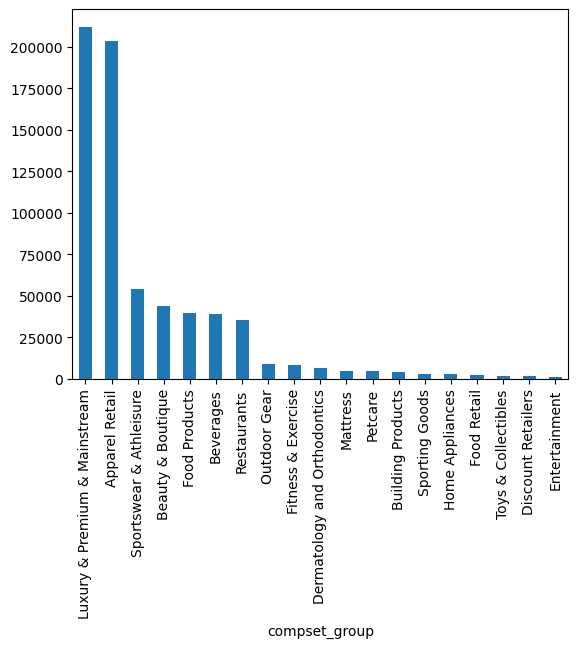

In [45]:
# plot count for each compset_group
df["compset_group"].value_counts().plot(kind="bar")

# print a dataframe with the count for each compset_group
df["compset_group"].value_counts().reset_index()

We create following broader categories for the compset_group:

1. **Luxury & Premium & Mainstream**
   - Luxury & Premium & Mainstream 
   - Entertainment 

2. **Retail**
   - Apparel Retail
   - Sportswear & Athleisure 
   - Outdoor Gear 
   - Sporting Goods 
   - Toys & Collectibles 
   - Discount Retailers 

3. **Beauty & Personal Care**
   - Beauty & Boutique 
   - Dermatology and Orthodontics
   - Petcare

4. **Food & Beverages**
   - Food Products 
   - Beverages 
   - Restaurants 
   - Food Retail

5. **Home Improvement & Appliances**
   - Home Appliances 
   - Building Products 
   - Mattress 


In [46]:
# assign the new name to each old compset_group
df["compset_group"] = df["compset_group"].replace({
    "Luxury & Premium & Mainstream": "Luxury & Premium & Mainstream & Entertainment",
    "Apparel Retail": "Retail",
    "Sportswear & Athleisure": "Retail",
    "Outdoor Gear": "Retail",
    "Sporting Goods": "Retail",
    "Toys & Collectibles": "Retail",
    "Discount Retailers": "Retail",
    "Beauty & Boutique": "Beauty & Personal Care",
    "Dermatology and Orthodontics": "Beauty & Personal Care",
    "Petcare": "Beauty & Personal Care",
    "Food Products": "Food & Beverages",
    "Beverages": "Food & Beverages",
    "Restaurants": "Food & Beverages",
    "Food Retail": "Food & Beverages",
    "Home Appliances": "Home Improvement & Appliances",
    "Building Products": "Home Improvement & Appliances",
    "Mattress": "Home Improvement & Appliances",
    "Entertainment": "Luxury & Premium & Mainstream & Entertainment",
    "Fitness & Exercise": "Retail"
})


compset_group
Retail                                           281294
Luxury & Premium & Mainstream & Entertainment    212906
Food & Beverages                                 116521
Beauty & Personal Care                            54706
Home Improvement & Appliances                     11131
Name: count, dtype: int64

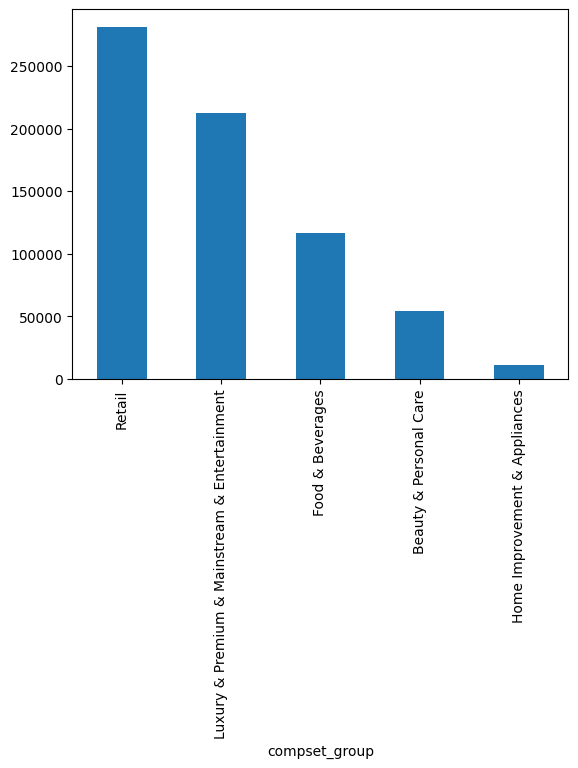

In [47]:
# # check that it worked
df["compset_group"].value_counts().plot(kind="bar")
df["compset_group"].value_counts()

Maybe we can merge entertainment in first category since we would not be able to isolate the variance provided by the category.

In [48]:
df.head()

,period_end_date,compset_group,compset,business_entity_doing_business_as_name,legal_entity_name,followers,pictures,videos,comments,likes
0,2019-12-07,Luxury & Premium & Mainstream & Entertainment,Soft Luxury,Versace,Capri Holdings,22066189.0,97.0,13.0,16239.0,6112205.0
1,2021-01-30,Luxury & Premium & Mainstream & Entertainment,Luxury & Premium & Mainstream,Versace,Capri Holdings,24289963.0,54.0,2.0,13358.0,3189144.0
2,2016-05-14,Luxury & Premium & Mainstream & Entertainment,Soft Luxury,Versace,Capri Holdings,7137442.0,42.0,8.0,15894.0,2152955.0
3,2019-04-20,Luxury & Premium & Mainstream & Entertainment,Luxury & Premium & Mainstream,Versace,Capri Holdings,18901125.0,73.0,9.0,26762.0,5224916.0
4,2023-03-25,Luxury & Premium & Mainstream & Entertainment,US Softlines Analyst Interest List,Versace,Capri Holdings,30251374.0,54.0,10.0,25681.0,5760987.0


In [49]:
# one-hot encode compset_group and remove compset_group
df = pd.get_dummies(df, columns=["compset_group"], prefix="compset_group")

### feature 4: compset

In [50]:
# we discovered that companies have different compsets, but the numerical data is aggregetated already,
# so it seems like they get more ...

df[df["business_entity_doing_business_as_name"] == "Burberry"].head()

,period_end_date,compset,business_entity_doing_business_as_name,legal_entity_name,followers,pictures,videos,comments,likes,compset_group_Beauty & Personal Care,compset_group_Food & Beverages,compset_group_Home Improvement & Appliances,compset_group_Luxury & Premium & Mainstream & Entertainment,compset_group_Retail
65825,2017-09-09,US Softlines Analyst Interest List,Burberry,Burberry,10009175.0,32.0,2.0,2429.0,697305.0,False,False,False,True,False
65826,2020-08-01,Global Luxury Analysts Interest List,Burberry,Burberry,17239745.0,53.0,10.0,8379.0,2071170.0,False,False,False,True,False
65827,2021-10-23,Soft Luxury,Burberry,Burberry,18440173.0,31.0,1.0,5394.0,878691.0,False,False,False,True,False
65828,2016-05-28,Luxury & Premium & Mainstream,Burberry,Burberry,6810749.0,37.0,6.0,7727.0,1644776.0,False,False,False,True,False
65829,2015-07-11,Global Luxury Analysts Interest List,Burberry,Burberry,3958495.0,50.0,8.0,8952.0,1918501.0,False,False,False,True,False


In [51]:
# unique values
df['compset'].unique()

array(['Soft Luxury', 'Luxury & Premium & Mainstream',
       'US Softlines Analyst Interest List',
       'Global Luxury Analysts Interest List', 'Coffee', 'Restaurants',
       'Beverages', 'Sports drinks', 'Energy drinks', 'Fast Fashion',
       'Omnichannel Apparel Retail', 'Apparel Retail',
       'US Department Store', 'Latam Apparel Retail', 'Food Products',
       'Snack Bars', 'Pasta Sauce', 'Ecommerce Apparel Retail',
       'Ecommerce Mainstream Apparel Retail', 'Sporting Goods',
       'Casual Dining', 'Hard Luxury', 'Sportswear & Athleisure',
       'Athleisure', 'Footwear', 'Beauty & Boutique', 'Building Products',
       'Sportswear', 'Petcare', 'Premium Brands', 'QSR', 'Alcohol',
       'Toys & Collectibles', 'Mattress', 'Fitness & Exercise',
       'US Discount Store', 'Ecommerce Luxury Apparel Retail',
       'Plant-Based Meat', 'Food Retail', 'Discount Retailers',
       'Mid-Range Watch & Jewelry', 'Outdoor Gear', 'Plant-Based Dairy',
       'Mainstream Brands', 'De

compset
US Softlines Analyst Interest List      111924
Apparel Retail                           68886
Luxury & Premium & Mainstream            64086
Beauty & Boutique                        43811
Global Luxury Analysts Interest List     28778
Omnichannel Apparel Retail               24594
Sportswear & Athleisure                  20445
Food Products                            19941
Beverages                                19598
Ecommerce Apparel Retail                 19159
Fast Fashion                             18826
Soft Luxury                              18715
Restaurants                              17662
Hard Luxury                              14500
Alcohol                                  12912
Sportswear                               12256
Premium Brands                           11670
Footwear                                 10366
Ecommerce Mainstream Apparel Retail       9008
Fitness & Exercise                        8523
Mid-Range Watch & Jewelry                 8014
Outdo

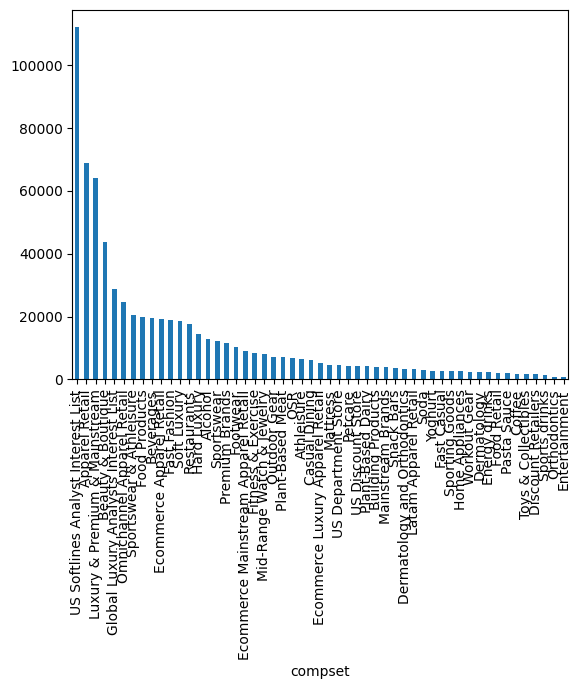

In [52]:
# unique value counts
df['compset'].value_counts().plot(kind="bar")
df['compset'].value_counts()

In [53]:
# does each company have a unique compset? assign a df in which we have the count of unique compsets for each brand
temp = df.groupby("business_entity_doing_business_as_name")["compset"].nunique().reset_index()
temp

,business_entity_doing_business_as_name,compset
0,24S,4
1,3.1 Phillip Lim,3
2,3CE,1
3,A. Lange & Soehne,2
4,ANIMALE,1
...,...,...
700,bareMinerals,1
701,dd's Discounts,3
702,e.l.f.,1
703,iRobot,1


<Axes: xlabel='compset'>

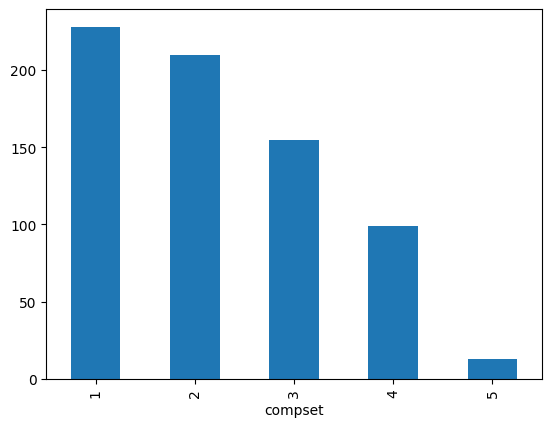

In [54]:
# count number of companies for each count
temp["compset"].value_counts().plot(kind="bar")

We choose to drop the feature because of the amount of unique values, instead of one-hot-encoding it.

In [55]:
# drop
df.drop(columns=["compset"], inplace=True)

### feature 5: business_entity_doing_business_as_name

In [56]:
# business_entity_doing_business_as_name
# unique names
df['business_entity_doing_business_as_name'].unique()

array(['Versace', "Tim Horton's", 'Gatorade', 'Monster Energy', 'Aritzia',
       'Lovisa', 'Saks Fifth Avenue', 'Ferragamo', 'Riachuelo',
       'Louis Vuitton', 'Nature Valley', "Rao's", 'YesStyle',
       'Academy Sports + Outdoors', 'Outback Steakhouse', 'Cartier',
       'Costa Coffee', 'Lululemon', 'Clif Bar', 'Richards',
       'Steve Madden', 'DTLR', 'IL MAKIAGE', 'Topshop', 'Boral',
       'Skechers', 'Balmain Beauty', 'Meow Mix', 'Michael Kors', 'Chloe',
       'Wingstop', 'Absolut', 'Miniso', 'TAG Heuer', 'Helix',
       'C&A Brasil', 'YSL Beauty', 'C&A', 'Saint Laurent', 'Mirror',
       'Dermalogica', 'Saks Off Fifth', 'LORO PIANA', 'Topman', 'Garnier',
       'The RealReal', 'Beyond Meat', 'Volcom', 'Hourglass',
       'Pure Farmland', 'Esprit', 'Buffalo Wild Wings', 'Boozt', 'Aldi',
       'Banana Republic', 'Sam Edelman', 'Lord + Taylor', 'Blink Fitness',
       'BodyArmor', 'Tempur', 'Dollar Tree', 'MVMT', 'Champs Sports',
       'Macpac', 'Burberry', 'Certina', 'Nine 

In [57]:
# count of unique names
df['business_entity_doing_business_as_name'].nunique()

705

In [58]:
# sort the dataframe
df = df.sort_values(by="period_end_date")

In [88]:
df.dropna(subset=['followers'], inplace=True)

In [91]:
numerical_cols = ["followers", "pictures", "videos", "comments", "likes"]

# missing values per column
for col in numerical_cols:
    print(f"{col}: {df[col].isnull().sum()}")

followers: 0
pictures: 7610
videos: 9264
comments: 7871
likes: 7524


In [86]:
# Let´s handle missing values

In [94]:
# Assuming your dataframe is named 'df'
cleaned_df = df.dropna(subset=['pictures', 'videos', 'comments', 'likes'], how='all')

In [98]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546452 entries, 96161 to 310532
Data columns (total 13 columns):
 #   Column                                                       Non-Null Count   Dtype         
---  ------                                                       --------------   -----         
 0   period_end_date                                              546452 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name                       546452 non-null  object        
 2   legal_entity_name                                            546452 non-null  object        
 3   followers                                                    546452 non-null  float64       
 4   pictures                                                     546366 non-null  float64       
 5   videos                                                       544712 non-null  float64       
 6   comments                                                     546105 non-null  float64       
 7   lik

We still have missing values in pictures, videos and comments: we just use backward fill: as we dont have the data we dont want to get "signals" where they dont exists

In [100]:
columns_to_fill = ['comments', 'videos', 'pictures']

# Iterate over each column to fill missing values
for column in columns_to_fill:
    # Iterate over unique companies
    for company in cleaned_df["business_entity_doing_business_as_name"].unique():
        # Create a mask for the current company
        company_mask = cleaned_df["business_entity_doing_business_as_name"] == company
        
        # Fill remaining missing values using forward fill and backward fill
        cleaned_df.loc[company_mask, column] = cleaned_df.loc[company_mask, column].bfill()

In [101]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546452 entries, 96161 to 310532
Data columns (total 13 columns):
 #   Column                                                       Non-Null Count   Dtype         
---  ------                                                       --------------   -----         
 0   period_end_date                                              546452 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name                       546452 non-null  object        
 2   legal_entity_name                                            546452 non-null  object        
 3   followers                                                    546452 non-null  float64       
 4   pictures                                                     546452 non-null  float64       
 5   videos                                                       546452 non-null  float64       
 6   comments                                                     546226 non-null  float64       
 7   lik

Our goal will be to be able to generate some insights about what will be happening on the stock market. For that only some companies will be selected, specifically the ones that we have the financial data

In [102]:
# Data with the Ticks for getting the financial data:
companies = pd.read_csv("public-companies.csv")

In [109]:
#

In [103]:
public_companies = pd.merge(companies, df, left_on='Company Name', right_on='legal_entity_name', how='inner')


In [104]:
public_companies.drop_duplicates(inplace=True)

In [105]:
grouped_df = public_companies.groupby(["legal_entity_name", 'period_end_date'], as_index=False).sum()

In [106]:
grouped_df

,legal_entity_name,period_end_date,Company Name,Ticker,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes,compset_group_Beauty & Personal Care,compset_group_Food & Beverages,compset_group_Home Improvement & Appliances,compset_group_Luxury & Premium & Mainstream & Entertainment,compset_group_Retail
0,AbbVie,2021-07-24,AbbVie,ABBV,Dysport,5477.0,3.0,4.0,0.0,180.0,1,0,0,0,0
1,AbbVie,2021-07-31,AbbVie,ABBV,Dysport,5761.0,5.0,4.0,0.0,246.0,1,0,0,0,0
2,AbbVie,2021-08-07,AbbVie,ABBV,Dysport,5933.0,5.0,3.0,0.0,222.0,1,0,0,0,0
3,AbbVie,2021-08-14,AbbVie,ABBV,Dysport,6104.0,5.0,3.0,0.0,252.0,1,0,0,0,0
4,AbbVie,2021-08-21,AbbVie,ABBV,Dysport,6354.0,5.0,2.0,0.0,248.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75028,iRobot Corp,2023-08-19,iRobot Corp,IRBT,iRobot,307679.0,90.0,59.0,2989.0,2124.0,0,0,1,0,0
75029,iRobot Corp,2023-08-26,iRobot Corp,IRBT,iRobot,307842.0,96.0,74.0,3092.0,2903.0,0,0,1,0,0
75030,iRobot Corp,2023-09-02,iRobot Corp,IRBT,iRobot,307980.0,94.0,71.0,3038.0,2574.0,0,0,1,0,0
75031,iRobot Corp,2023-09-09,iRobot Corp,IRBT,iRobot,308043.0,89.0,90.0,3044.0,2805.0,0,0,1,0,0


In [111]:
grouped_df.drop(columns=["Company Name", "business_entity_doing_business_as_name"], inplace=True)

In [113]:
grouped_df.to_csv("cleaned_data.csv", index=False)

In [ ]:

# Since you want to drop 'business_entity_doing_business_as_name', ensure it's not included in the sum
if 'business_entity_doing_business_as_name' in grouped_df.columns:
    grouped_df.drop(columns=['business_entity_doing_business_as_name'], inplace=True)

print(grouped_df)

In [65]:
public_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196393 entries, 0 to 455555
Data columns (total 15 columns):
 #   Column                                                       Non-Null Count   Dtype         
---  ------                                                       --------------   -----         
 0   Company Name                                                 196393 non-null  object        
 1   Ticker                                                       196393 non-null  object        
 2   period_end_date                                              196393 non-null  datetime64[ns]
 3   business_entity_doing_business_as_name                       196393 non-null  object        
 4   legal_entity_name                                            196393 non-null  object        
 5   followers                                                    156438 non-null  float64       
 6   pictures                                                     193429 non-null  float64       
 7   videos 

### check for duplicates

In [81]:
# check for duplicate rows
print("len(df):", len(df))
dup = df.duplicated().sum()
print("dup:", dup)

# drop duplicates
df.drop_duplicates(inplace=True)

len(df): 676558
dup: 378518


In [82]:
print("len(df):", len(df))
dup = df.duplicated().sum()
print("dup:", dup)

len(df): 298040
dup: 0


In [83]:
df.head()

,period_end_date,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes,compset_group_Beauty & Personal Care,compset_group_Food & Beverages,compset_group_Home Improvement & Appliances,compset_group_Luxury & Premium & Mainstream & Entertainment,compset_group_Retail
0,2019-12-07,Versace,22066189.0,97.0,13.0,16239.0,6112205.0,0,0,0,1,0
1,2021-01-30,Versace,24289963.0,54.0,2.0,13358.0,3189144.0,0,0,0,1,0
2,2016-05-14,Versace,7137442.0,42.0,8.0,15894.0,2152955.0,0,0,0,1,0
3,2019-04-20,Versace,18901125.0,73.0,9.0,26762.0,5224916.0,0,0,0,1,0
4,2023-03-25,Versace,30251374.0,54.0,10.0,25681.0,5760987.0,0,0,0,1,0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298040 entries, 0 to 704312
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count   Dtype         
---  ------                                                       --------------   -----         
 0   period_end_date                                              298040 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name                       298040 non-null  object        
 2   followers                                                    236313 non-null  float64       
 3   pictures                                                     294176 non-null  float64       
 4   videos                                                       288438 non-null  float64       
 5   comments                                                     293958 non-null  float64       
 6   likes                                                        294288 non-null  float64       
 7   co

In [85]:
# sort df company and date
df.sort_values(by=["business_entity_doing_business_as_name", "period_end_date"], inplace=True)

## numerical features

For numerical data we want to know where missing values appear, and where exactly before proceding.

We start with checking the period_end_dates (x-axis) now that the dataset is clean.

26
455


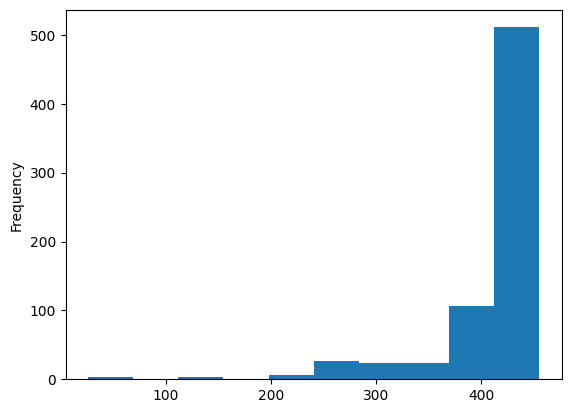

In [86]:
# create df with count of end dates per business_entity_doing_business_as_name
temp = df.groupby("business_entity_doing_business_as_name")["period_end_date"].count().reset_index()

# histogram of end dates
temp["period_end_date"].plot(kind="hist")

temp 

# min and max count of end dates
print(temp["period_end_date"].min())
print(temp["period_end_date"].max())

To provide useful insides we drop companies that have too little amount of entries.
We set the trashold at 100.

In [87]:
# To provide useful insides we drop companies that have too little amount of entries. We set the trashold at 100. This on the main df:
length = len(df)
df = df[df["business_entity_doing_business_as_name"].isin(temp[temp["period_end_date"] > 100]["business_entity_doing_business_as_name"])]
print("Dropped", length - len(df), "rows")

Dropped 173 rows


In [88]:
# time period covered by the data
print(df["period_end_date"].min())
print(df["period_end_date"].max())

2015-01-03 00:00:00
2023-09-16 00:00:00


### numerical cols

In [89]:
len(df)

297867

In [90]:
numerical_cols = ["followers", "pictures", "videos", "comments", "likes"]

# missing values per column
for col in numerical_cols:
    print(f"{col}: {df[col].isnull().sum()}")

followers: 61680
pictures: 3837
videos: 9560
comments: 4055
likes: 3725


In [91]:
# for each brand we want to know the starting row where afterwards we do not have missing values
# and keep only what comes afterwards

# Loop through each unique business entity
businesses = df['business_entity_doing_business_as_name'].unique()
cleaned_dfs = []

for business in businesses:
    business_df = df[df['business_entity_doing_business_as_name'] == business]
    business_df.reset_index(drop=True, inplace=True)  # Reset index for safe slicing
    
    # Finding the last row with any NaN values in the specified columns
    if business_df[numerical_cols].isnull().any(axis=1).any():
        last_na_position = business_df[numerical_cols].isnull().any(axis=1).cumsum().idxmax()
        # Proceed only if the last NA position is not the last row in DataFrame
        if last_na_position < len(business_df) - 1:
            clean_df = business_df.loc[last_na_position + 1:]
        else:
            continue  # Skip adding to cleaned_dfs if all rows contain NAs till the end
    else:
        clean_df = business_df  # No NAs at all

    cleaned_dfs.append(clean_df)

# Combine all cleaned dataframes back into a single dataframe
result_df = pd.concat(cleaned_dfs, ignore_index=True)

In [92]:
len(result_df)

230809

In [93]:
# check for remaining missing values
for col in numerical_cols:
    print(f"{col}: {result_df[col].isnull().sum()}")

followers: 0
pictures: 0
videos: 0
comments: 0
likes: 0


In [94]:
df[df['business_entity_doing_business_as_name'] == 'Zales']

,period_end_date,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes,compset_group_Beauty & Personal Care,compset_group_Food & Beverages,compset_group_Home Improvement & Appliances,compset_group_Luxury & Premium & Mainstream & Entertainment,compset_group_Retail
194816,2016-01-02,Zales,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0
194922,2016-01-09,Zales,NaN,NaN,1.0,14.0,378.0,0,0,0,1,0
194439,2016-01-16,Zales,NaN,2.0,1.0,35.0,1184.0,0,0,0,1,0
194727,2016-01-23,Zales,NaN,3.0,2.0,52.0,1906.0,0,0,0,1,0
194704,2016-01-30,Zales,NaN,4.0,2.0,58.0,2250.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
194539,2023-08-19,Zales,225156.0,14.0,2.0,66.0,1642.0,0,0,0,1,0
194859,2023-08-26,Zales,225555.0,11.0,1.0,58.0,1362.0,0,0,0,1,0
194430,2023-09-02,Zales,225606.0,7.0,3.0,58.0,1337.0,0,0,0,1,0
195022,2023-09-09,Zales,225696.0,5.0,3.0,29.0,952.0,0,0,0,1,0


<Axes: ylabel='Frequency'>

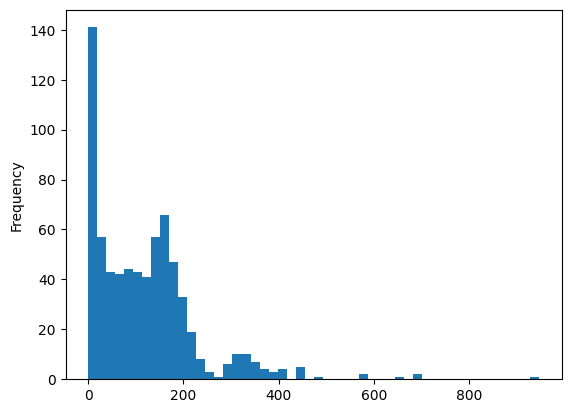

In [95]:
# missing values per brand
missing_values = df.groupby("business_entity_doing_business_as_name").apply(lambda x: x.isnull().sum()).sum(axis=1)

# hist
missing_values.plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

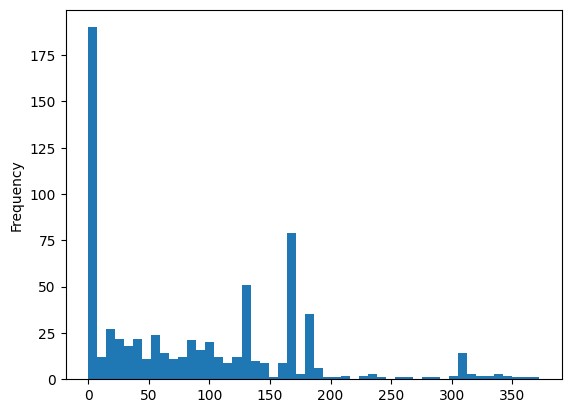

In [96]:
# missing values per brand in column followers
missing_followers = df.groupby("business_entity_doing_business_as_name")["followers"].apply(lambda x: x.isnull().sum())

# hist
missing_followers.plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

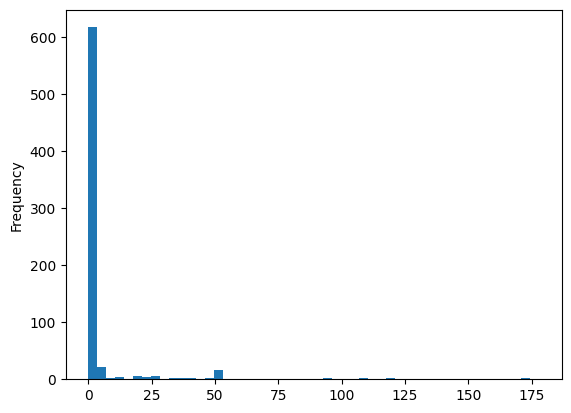

In [97]:
# missing values per brand in column pictures
missing_pictures = df.groupby("business_entity_doing_business_as_name")["pictures"].apply(lambda x: x.isnull().sum())

# hist
missing_pictures.plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

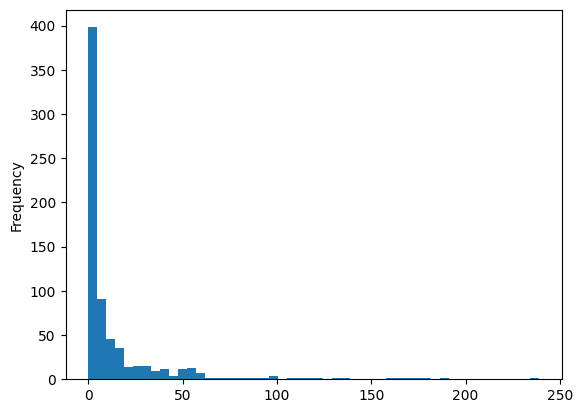

In [98]:
# missing values per brand in column videos
missing_videos = df.groupby("business_entity_doing_business_as_name")["videos"].apply(lambda x: x.isnull().sum())

# hist
missing_videos.plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

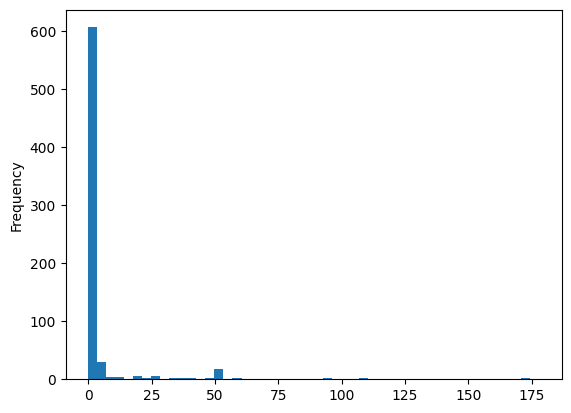

In [99]:
# missing values per brand in column comments
missing_comments = df.groupby("business_entity_doing_business_as_name")["comments"].apply(lambda x: x.isnull().sum())

# hist
missing_comments.plot(kind="hist", bins=50)